<a href="https://colab.research.google.com/github/rdemarqui/sentiment_analysis/blob/main/02%20Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

# Vectorization

In [127]:
import multiprocessing, os
from lightgbm import LGBMClassifier

In [15]:
cores = multiprocessing.cpu_count()
cores

2

In [16]:
path = os.getcwd()
path

'/content'

In [117]:
random_state = 42

In [ ]:
# Create Cross-Validation method

## Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import chain

In [17]:
try:
  df = pd.read_csv(os.path.join(path, 'data\preprocessed_corpus.zip'),
                   sep=',', compression='zip')
except:
  !wget https://github.com/rdemarqui/sentiment_analysis/raw/main/data/preprocessed_corpus.zip -q
  df = pd.read_csv(os.path.join(path, 'preprocessed_corpus.zip'),
                   sep=',', compression='zip')

In [22]:
columns = ['review_text_clean', 'review_text_clean_stop', 'review_text_clean_stem',
           'review_text_clean_stop_stem', 'review_text_clean_lemma', 'review_text_clean_stop_lemma',
           'overall_rating']
corpus = df[columns].copy()
corpus['overall_rating'] = corpus['overall_rating'].apply(lambda x: 1 if x >= 4 else 0)
print(corpus.shape)

(116058, 7)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(corpus.iloc[:, :-1], corpus.iloc[:, -1:],
                                                    test_size=0.2, random_state=random_state)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [41]:
X_train.head()

,review_text_clean,review_text_clean_stop,review_text_clean_stem,review_text_clean_stop_stem,review_text_clean_lemma,review_text_clean_stop_lemma
88875,bateria realmente muito boa fiquei meio receos...,bateria realmente boa fiquei meio receoso pore...,bat real muit boa fiq mei rece por part fic be...,bat real boa fiq mei rece por part fic bem fort,bateria realmente muito boa fiquei meio receos...,bateria realmente boa fiquei meio receoso pore...
581,minha filha gostou muito consegue utiliza lo s...,filha gostou consegue utiliza lo ajuda outras ...,minh filh gost muit conseg utiliz lo sem ajud ...,filh gost conseg utiliz lo ajud outr pesso gan...,meu filha gostar muito conseguir utilizar lo s...,filha gostar conseguir utilizar lo ajudar outr...
34525,bom custo beneficio produto lindo com uma otim...,bom custo beneficio produto lindo otima qualid...,bom cust benefici produt lind com uma otim qua...,bom cust benefici produt lind otim qual cheg a...,bom custo beneficio produto lir com um otimo q...,bom custo beneficio produto lir otimo qualidad...
96796,comprei meu pro ha dias um smartphone maravilh...,comprei pro dias smartphone maravilhoso camera...,compr meu pro ha dia um smartphon maravilh cam...,compr pro dia smartphon maravilh cam otim reso...,comprar meu pro ha dia um smartphone maravilho...,comprar pro dia smartphone maravilhoso camera ...
93967,nnao achava que este produto podese resolver m...,nnao achava produto podese resolver poblemas p...,nna ach que est produt podes resolv meu poblem...,nna ach produt podes resolv poblem poi pesso s...,nnao achar que este produto podeser resolver m...,nnao achar produto podeser resolver poblema po...


In [85]:
# Checking y proportion
print(f'Train proportion\n{y_train.value_counts()/y_train.shape[0]}')

Train proportion
overall_rating
1                 0.691985
0                 0.308015
dtype: float64.2


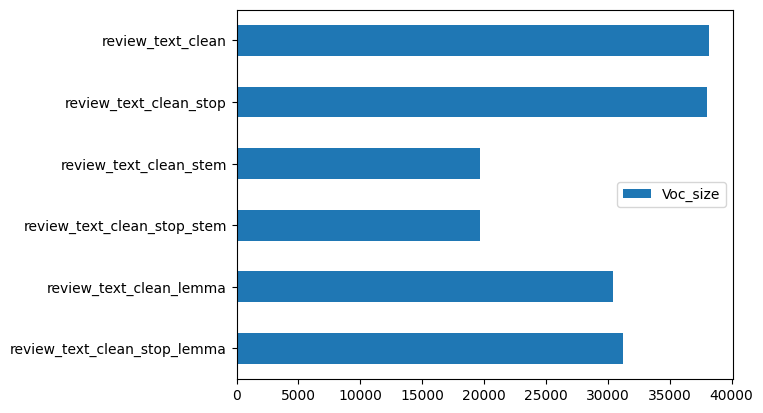

In [87]:
# Check Vocabulary size
voc_size = {}
for column in X_train.columns:
  full_text = ' '.join(X_train[column].tolist())
  words = full_text.split()
  vocabulary = set(words)
  voc_size[column] = len(vocabulary)

df_vocabulary_size = pd.DataFrame(list(voc_size.items()), columns=['Corpus', 'Voc_size'])
ax = df_vocabulary_size.plot.barh()
ax.set_yticklabels(df_vocabulary_size.Corpus)
ax.invert_yaxis();

## Sparse

### Bag of Word

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

In [118]:
def apply_bag_of_word(dataframe):
  for column in dataframe.columns:
    count_vectorizer = CountVectorizer(dtype=np.float32)
    bag_of_words = count_vectorizer.fit_transform(dataframe[column])

    return bag_of_words

In [119]:
ee = apply_bag_of_word(pd.DataFrame(X_train['review_text_clean_stop_stem']))

In [116]:
type(ee)

scipy.sparse._csr.csr_matrix

In [131]:
model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=random_state)

In [132]:
model.fit(ee, y_train.values.ravel());

In [101]:
print(str(X_train.loc[88876:88876, 'review_text_clean_stop_lemma']))

88876    produto excelente qualidade entregar rapido cu...
Name: review_text_clean_stop_lemma, dtype: object


In [ ]:
count_vectorizer = CountVectorizer()

In [ ]:
bag_of_words = count_vectorizer.fit_transform(corpus.motivo_CLEAN)

In [ ]:
similarity = 1 - cosine(bag_of_words[1].toarray().flatten(),
                        bag_of_words[2].toarray().flatten())
similarity

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
X = corpus.values.tolist()
X = list(chain.from_iterable(X))
X[0:4]

In [ ]:
tf_idf_vectorizer = TfidfVectorizer()

In [ ]:
tf_idf = tf_idf_vectorizer.fit_transform(corpus.motivo_CLEAN)

In [ ]:
tf_idf

In [ ]:
similarity = 1 - cosine(tf_idf[1].toarray().flatten(),
                        tf_idf[3].toarray().flatten())
similarity

## Dense

### Word2vec

In [ ]:
from gensim.models import Word2Vec

* Vetores: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc
* Treinamento: https://www.youtube.com/watch?v=wjsKN4uyH90
* Tutorial: https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
* Teoria: https://towardsdatascience.com/word2vec-explained-49c52b4ccb71
* Documentação: https://www.nltk.org/howto/portuguese_en.html

**Spacy**

https://spacy.io/models/pt

In [ ]:
import spacy
nlp = spacy.load('pt_core_news_sm')

In [ ]:
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc)]

In [ ]:
X = corpus.values.tolist()[:3]
X = [spacy_tokenizer(text[0]) for text in X]
X[0:2]

**NLTK**

In [ ]:
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [ ]:
X = corpus.values.tolist()
X = [word_tokenize(text[0], language='portuguese') for text in X]
X[0:2]

#### CBOW - Continuous Bag of Words

In [ ]:
#model.wv.key_to_index

In [ ]:
w2v_cbow = Word2Vec(sg=0, #CBOW
                    min_count=20,
                    window=2,
                    vector_size=300,
                    sample=6e-5,
                    alpha=0.03,
                    min_alpha=0.0007,
                    negative=20,
                    workers=cores-1)

In [ ]:
w2v_cbow.build_vocab(X)

In [ ]:
w2v_cbow.train(X,
               total_examples=w2v_cbow.corpus_count,
               epochs=30,
               report_delay=1)

In [ ]:
similarity = 1 - cosine(np.mean(w2v_cbow.wv[X[1]].T, axis=1),
                        np.mean(w2v_cbow.wv[X[3]].T, axis=1))
similarity

#### SG - Skip-Gram

In [ ]:
w2v_skgram = Word2Vec(sg=1, #skip-gram
                     min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [ ]:
w2v_skgram.build_vocab(X)

In [ ]:
w2v_skgram.train(X,
                 total_examples=w2v_skgram.corpus_count,
                 epochs=30,
                 report_delay=1)

In [ ]:
similarity = 1 - cosine(np.mean(w2v_skgram.wv[X[1]].T, axis=1),
                        np.mean(w2v_skgram.wv[X[1]].T, axis=1))
similarity

### FastText

In [ ]:
from gensim.models import FastText

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [ ]:
X = corpus.values.tolist()
X = [word_tokenize(text[0], language='portuguese') for text in X]
X[0:2]

In [ ]:
fast_text = FastText(vector_size=4, window=3, min_count=1)

In [ ]:
fast_text.build_vocab(corpus_iterable=X)

In [ ]:
fast_text.train(corpus_iterable=X, total_examples=len(X), epochs=10)

In [ ]:
similarity = 1 - cosine(np.mean(fast_text.wv[X[1]].T, axis=1),
                        np.mean(fast_text.wv[X[3]].T, axis=1))
similarity

### Combined

#### Word2vec CBOW + TF-IDF

#### Word2vec SG + TF-IDF

#### FastTest + TF-IDF

In [ ]:
tfidf_sent_vectors_ft = [] # the tfidf-ft for each sentence/review is stored in this list
row = 0
errors = 0
tfidf_feat = tf_idf_vectorizer.get_feature_names_out()
X = corpus.values.tolist()
X = [word_tokenize(text[0], language='portuguese') for text in X]

for sent in X[:]: # for each review/sentence
    vec_shape = fast_text.wv[tfidf_feat[0]].shape[0]
    sent_vec = np.zeros(vec_shape) #
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = fast_text.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf_idx = np.where(tfidf_feat == word)[0][0]
            tfidf_weight = tf_idf[row, tfidf_idx]
            sent_vec += (vec * tfidf_weight)
            weight_sum += tfidf_weight
        except:
            errors +=1
            print(f"Error in {word}")
            pass
    sent_vec /= weight_sum

    tfidf_sent_vectors_ft.append(sent_vec)
    row += 1
print('errors noted: '+str(errors))

In [ ]:
similarity = 1 - cosine(tfidf_sent_vectors_ft[1],
                        tfidf_sent_vectors_ft[3])
similarity

### Doc2Vec

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://aitechtrend.com/doc2vec-made-easy-a-step-by-step-guide-to-gensim-implementation/

In [ ]:
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from nltk.tokenize import word_tokenize

In [ ]:
X = corpus.values.tolist()
X = list(chain.from_iterable(X))

tagged_docs = [TaggedDocument(words=word_tokenize(doc), tags=[str(i)]) for i, doc in enumerate(X)]
tagged_docs[:4]

#### DBOW - Distributed Bag of Words

In [ ]:
d2v_dbow = Doc2Vec(dm=0,
                   vector_size=300,
                   negative=5,
                   hs=0,
                   min_count=2,
                   sample=0,
                   workers=cores)

In [ ]:
d2v_dbow.build_vocab(tagged_docs)

In [ ]:
d2v_dbow.train(tagged_docs, total_examples=d2v_dbow.corpus_count, epochs=50)

In [ ]:
similarity = 1 - cosine(d2v_dbow.infer_vector(word_tokenize(X[1])),
                        d2v_dbow.infer_vector(word_tokenize(X[3])))
similarity

#### DM - Distributed Memory

In [ ]:
# 0.025
d2v_dm = Doc2Vec(dm=1,
                 vector_size=300,
                 negative=5,
                 hs=0,
                 min_count=2,
                 sample=0,
                 workers=cores)

In [ ]:
d2v_dm.build_vocab(tagged_docs)

In [ ]:
d2v_dm.train(tagged_docs, total_examples=d2v_dm.corpus_count, epochs=50)

In [ ]:
similarity = 1 - cosine(d2v_dm.infer_vector(word_tokenize(X[1])),
                        d2v_dm.infer_vector(word_tokenize(X[3])))
similarity

#### Concatenated

In [ ]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [ ]:
d2v_combined = ConcatenatedDoc2Vec([d2v_dbow, d2v_dm])

In [ ]:
similarity = 1 - cosine(d2v_combined.infer_vector(word_tokenize(X[1])),
                        d2v_combined.infer_vector(word_tokenize(X[3])))
similarity

### Transformers

* https://huggingface.co/models?pipeline_tag=sentence-similarity&language=pt&sort=trending
* https://huggingface.co/blog/how-to-train-sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
# https://www.sbert.net/

In [ ]:
X = corpus.values.tolist()
X = list(chain.from_iterable(X))
X[0:2]

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
#model = SentenceTransformer('Legal-BERTimbau-sts-large-ma-v3')

In [ ]:
#Sentences are encoded by calling model.encode()
embeddings = model.encode(X)

In [ ]:
embeddings[0].shape

In [ ]:
similarity = 1 - cosine(embeddings[1],
                        embeddings[3])
similarity

## References

* http://hunterheidenreich.com/blog/intro-to-word-embeddings/